# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [1]:
!pip install labelme tensorflow opencv-python matplotlib albumentations

  Using cached labelme-5.4.1-py3-none-any.whl
  Using cached tensorflow-2.15.0-cp39-cp39-win_amd64.whl (2.1 kB)
  Using cached opencv_python-4.9.0.80-cp37-abi3-win_amd64.whl (38.6 MB)
  Using cached matplotlib-3.8.2-cp39-cp39-win_amd64.whl (7.6 MB)
  Using cached numpy-1.26.3-cp39-cp39-win_amd64.whl (15.8 MB)
  Using cached termcolor-2.4.0-py3-none-any.whl (7.7 kB)
  Using cached pillow-10.2.0-cp39-cp39-win_amd64.whl (2.6 MB)
  Using cached imgviz-1.7.5-py3-none-any.whl
  Using cached colorama-0.4.6-py2.py3-none-any.whl (25 kB)
  Using cached tensorflow_intel-2.15.0-cp39-cp39-win_amd64.whl (300.8 MB)
  Using cached tensorflow_estimator-2.15.0-py2.py3-none-any.whl (441 kB)
  Using cached h5py-3.10.0-cp39-cp39-win_amd64.whl (2.7 MB)
  Using cached gast-0.5.4-py3-none-any.whl (19 kB)
  Using cached packaging-23.2-py3-none-any.whl (53 kB)
  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
  Using cached tensorboard-2.15.1-py3-none-any.whl (5.5 MB)
  Using cached google_pasta-0.2.0-py3-

You should consider upgrading via the 'S:\Deep Learning\trial\FaceDetect\Scripts\python.exe -m pip install --upgrade pip' command.


### 1.2 Collect Images Using OpenCV

In [8]:
import os
import time
import uuid
import cv2

In [3]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [6]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

### 1.3 Annotate Images with LabelMe

In [7]:
!labelme

2024-01-16 00:00:35,856 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\SAURABH\.labelmerc


# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [9]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [9]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [10]:
tf.config.list_physical_devices('GPU')

[]

### 2.3 Load Image into TF Data Pipeline

In [11]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [12]:
images.as_numpy_iterator().next()

b'data\\images\\bb083d2e-b3d3-11ee-a9de-fcb3bcf93504.jpg'

In [13]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [14]:
images = images.map(load_image)

In [15]:
images.as_numpy_iterator().next()

array([[[ 54,  37,   9],
        [ 54,  37,   9],
        [ 53,  36,   8],
        ...,
        [ 67,  67,  57],
        [ 63,  63,  53],
        [ 64,  64,  54]],

       [[ 53,  36,   8],
        [ 53,  36,   8],
        [ 53,  36,   8],
        ...,
        [ 62,  62,  52],
        [ 61,  61,  51],
        [ 61,  61,  51]],

       [[ 53,  36,  10],
        [ 54,  37,  11],
        [ 54,  37,  11],
        ...,
        [ 59,  59,  51],
        [ 59,  59,  51],
        [ 59,  59,  51]],

       ...,

       [[115, 116, 108],
        [114, 116, 105],
        [114, 116, 105],
        ...,
        [ 79,  92,  83],
        [ 71,  84,  77],
        [ 75,  88,  81]],

       [[115, 116, 110],
        [115, 116, 108],
        [115, 117, 106],
        ...,
        [ 55,  71,  60],
        [ 55,  71,  61],
        [ 58,  74,  64]],

       [[114, 115, 109],
        [114, 115, 107],
        [115, 116, 108],
        ...,
        [ 41,  57,  46],
        [ 46,  62,  52],
        [ 38,  54,  44]]

In [16]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

### 2.4 View Raw Images with Matplotlib

In [17]:
image_generator = images.batch(4).as_numpy_iterator()

In [18]:
plot_images = image_generator.next()

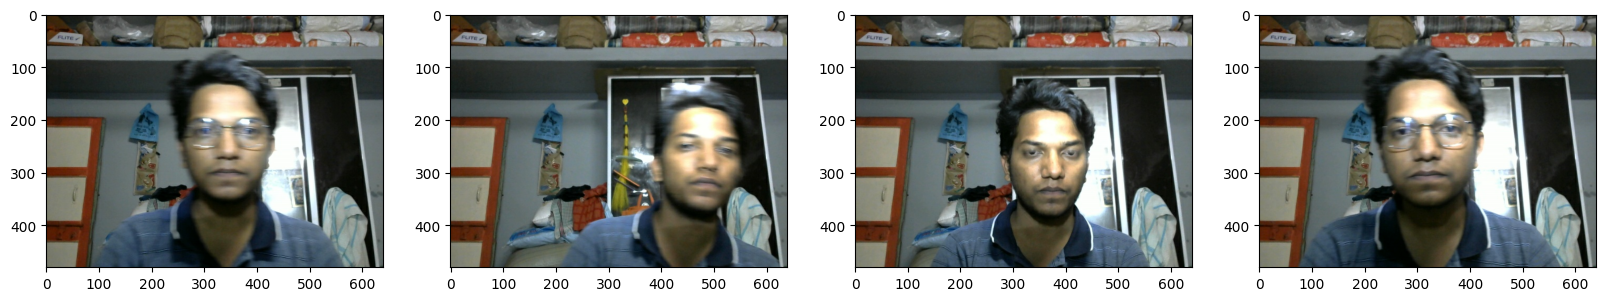

In [19]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [20]:
90*.7 # 63 to train

62.99999999999999

In [21]:
90*.15 # 14 and 13 to test and val

13.5

### 3.2 Move the Matching Labels

In [29]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [10]:
import albumentations as alb

In [24]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [31]:
img = cv2.imread(os.path.join('data','train', 'images','b9b8811c-b3d3-11ee-95d2-fcb3bcf93504.jpg'))

In [32]:
with open(os.path.join('data', 'train', 'labels', 'b9b8811c-b3d3-11ee-95d2-fcb3bcf93504.json'), 'r') as f:
    label = json.load(f)

In [33]:
label['shapes'][0]['points']

[[225.46875, 143.64583333333331], [393.1770833333333, 353.0208333333333]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [34]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [35]:
coords

[225.46875, 143.64583333333331, 393.1770833333333, 353.0208333333333]

In [36]:
coords = list(np.divide(coords, [640,480,640,480]))

In [37]:
coords

[0.352294921875, 0.29926215277777773, 0.6143391927083333, 0.7354600694444444]

### 4.4 Apply Augmentations and View Results

In [38]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [39]:
augmented['bboxes'][0][2:]

(0.8789583333333333, 0.7489351851851851)

In [40]:
augmented['bboxes']

[(0.5062731481481484,
  0.28365740740740736,
  0.8789583333333333,
  0.7489351851851851)]

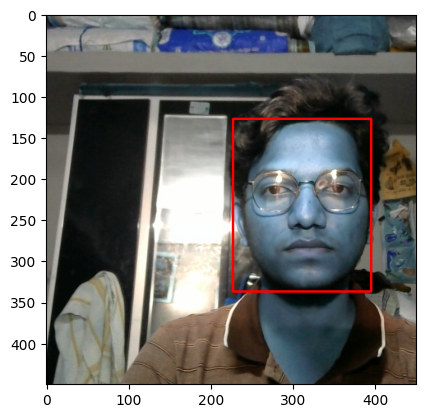

In [41]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [42]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

image must be numpy array type
x_max is less than or equal to x_min for bbox [0.5533040364583333, 0.6920572916666666, 0.3050944010416667, 0.3263888888888888, 'face'].


### 5.2 Load Augmented Images to Tensorflow Dataset

In [43]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [44]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [45]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [46]:
train_images.as_numpy_iterator().next()

array([[[0.22365196, 0.2833946 , 0.2716299 ],
        [0.7541054 , 0.8020833 , 0.7896446 ],
        [0.77389705, 0.828799  , 0.828799  ],
        ...,
        [0.16568628, 0.24019608, 0.30588236],
        [0.16648284, 0.2372549 , 0.29215688],
        [0.1764706 , 0.23915441, 0.30833334]],

       [[0.19203432, 0.25968137, 0.2583946 ],
        [0.74552697, 0.790625  , 0.78566176],
        [0.77794117, 0.8201593 , 0.82800245],
        ...,
        [0.19178921, 0.266299  , 0.32512254],
        [0.18627451, 0.26078433, 0.3156863 ],
        [0.19068627, 0.26519608, 0.32371324]],

       [[0.20514706, 0.26593137, 0.26721814],
        [0.7814951 , 0.8197304 , 0.8280637 ],
        [0.80036765, 0.84166664, 0.8582721 ],
        ...,
        [0.21770833, 0.284375  , 0.3471201 ],
        [0.20876226, 0.28278187, 0.33768383],
        [0.20900735, 0.28351715, 0.3398897 ]],

       ...,

       [[0.6627451 , 0.67058825, 0.61715686],
        [0.6601103 , 0.66795343, 0.6248162 ],
        [0.65300244, 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [47]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [48]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [49]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [50]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [51]:
train_labels.as_numpy_iterator().next()

(array([0], dtype=uint8), array([0., 0., 0., 0.], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [52]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3720, 3720, 840, 840, 780, 780)

### 7.2 Create Final Datasets (Images/Labels)

In [53]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [54]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [55]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [56]:
train.as_numpy_iterator().next()[1]

(array([[0],
        [0],
        [1],
        [1],
        [0],
        [0],
        [1],
        [1]], dtype=uint8),
 array([[0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.1537, 0.1702, 0.839 , 0.9805],
        [0.4978, 0.2349, 0.9053, 0.7305],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.0753, 0.2332, 0.529 , 0.785 ],
        [0.4329, 0.3433, 0.8345, 0.818 ]], dtype=float16))

### 7.3 View Images and Annotations

In [57]:
data_samples = train.as_numpy_iterator()

In [58]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


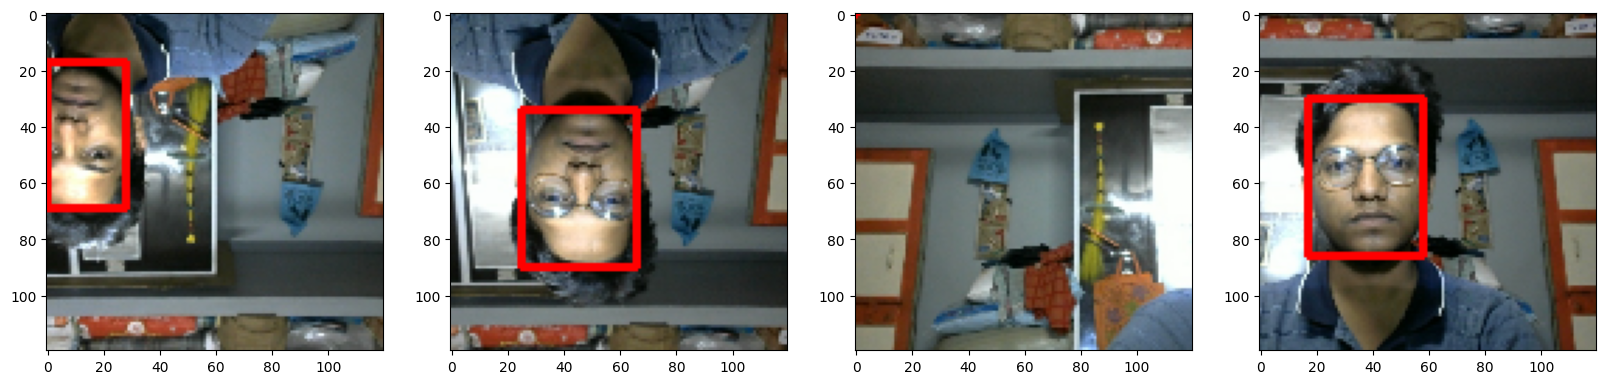

In [60]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))

for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]

    sample_image_umat = cv2.UMat(sample_image)

    cv2.rectangle(sample_image_umat,
                  tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)),
                  (255, 0, 0), 2)

    sample_image_with_rectangle = np.asarray(sample_image_umat.get())

    ax[idx].imshow(sample_image_with_rectangle)

plt.show()

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [62]:
vgg = VGG16(include_top=False)

In [63]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.3 Build instance of Network

In [64]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [65]:
facetracker = build_model()

In [66]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_2[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d (Glob  (None, 512)                  0         ['vgg16[0][0]']               
 alMaxPooling2D)                                                                                  
                                                                                              

In [67]:
X, y = train.as_numpy_iterator().next()

In [68]:
X.shape

(8, 120, 120, 3)

In [69]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 1s 889ms/step


In [70]:
classes, coords

(array([[0.34507445],
        [0.4255258 ],
        [0.3728536 ],
        [0.33713937],
        [0.40604782],
        [0.34001547],
        [0.39234906],
        [0.32052034]], dtype=float32),
 array([[0.37889344, 0.40199304, 0.6100887 , 0.72665155],
        [0.35315597, 0.48252478, 0.6735301 , 0.68983126],
        [0.39679486, 0.3445172 , 0.5923772 , 0.577545  ],
        [0.4662624 , 0.37732378, 0.6115072 , 0.64675593],
        [0.35624367, 0.36854422, 0.63703185, 0.7595263 ],
        [0.35704917, 0.42869154, 0.6601021 , 0.645336  ],
        [0.3320783 , 0.4342174 , 0.6508603 , 0.6943246 ],
        [0.3522984 , 0.43565974, 0.58321106, 0.6577955 ]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [71]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [73]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=batches_per_epoch,
    decay_rate=lr_decay,
    staircase=False
)

In [74]:
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

### 9.2 Create Localization Loss and Classification Loss

In [75]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [76]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [77]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=1.4089459>

In [78]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=1.005714>

In [79]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=1.4089459>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [80]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [81]:
model = FaceTracker(facetracker)

In [82]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [83]:
logdir='logs'

In [84]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [85]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
465/465 [==============================] - 827s 2s/step - total_loss: 0.2518 - class_loss: 0.0656 - regress_loss: 0.2190 - val_total_loss: 0.0885 - val_class_loss: 0.0752 - val_regress_loss: 0.0509
Epoch 2/10
465/465 [==============================] - 836s 2s/step - total_loss: 0.0670 - class_loss: 0.0118 - regress_loss: 0.0612 - val_total_loss: 0.0090 - val_class_loss: 8.9407e-08 - val_regress_loss: 0.0090
Epoch 3/10
465/465 [==============================] - 812s 2s/step - total_loss: 0.0669 - class_loss: 0.0118 - regress_loss: 0.0610 - val_total_loss: 0.5236 - val_class_loss: 0.6560 - val_regress_loss: 0.1956
Epoch 4/10
465/465 [==============================] - 847s 2s/step - total_loss: 0.0669 - class_loss: 0.0118 - regress_loss: 0.0611 - val_total_loss: 0.2720 - val_class_loss: 0.0233 - val_regress_loss: 0.2604
Epoch 5/10
465/465 [==============================] - 981s 2s/step - total_loss: 0.0669 - class_loss: 0.0117 - regress_loss: 0.0610 - val_total_loss: 0.0342 - v

### 10.3 Plot Performance

In [86]:
hist.history

{'total_loss': [0.05032121762633324,
  0.04832615703344345,
  0.03497813642024994,
  0.042993929237127304,
  0.026097020134329796,
  0.03707049787044525,
  0.027140449732542038,
  0.018549446016550064,
  0.09291591495275497,
  0.051672469824552536],
 'class_loss': [0.014416277408599854,
  0.005283788777887821,
  0.009810585528612137,
  0.010052480734884739,
  1.391089699609438e-05,
  0.009449920617043972,
  0.0007598942029289901,
  0.002734886482357979,
  0.022497007623314857,
  0.0027809063903987408],
 'regress_loss': [0.04311307892203331,
  0.04568426311016083,
  0.03007284179329872,
  0.03796768933534622,
  0.026090065017342567,
  0.03234553709626198,
  0.02676050178706646,
  0.0171820018440485,
  0.08166740834712982,
  0.05028201639652252],
 'val_total_loss': [0.08851620554924011,
  0.009026847779750824,
  0.5236185789108276,
  0.2720242440700531,
  0.03421466425061226,
  0.05602354183793068,
  0.03573526442050934,
  0.02542564459145069,
  0.018773632124066353,
  0.0712161958217620

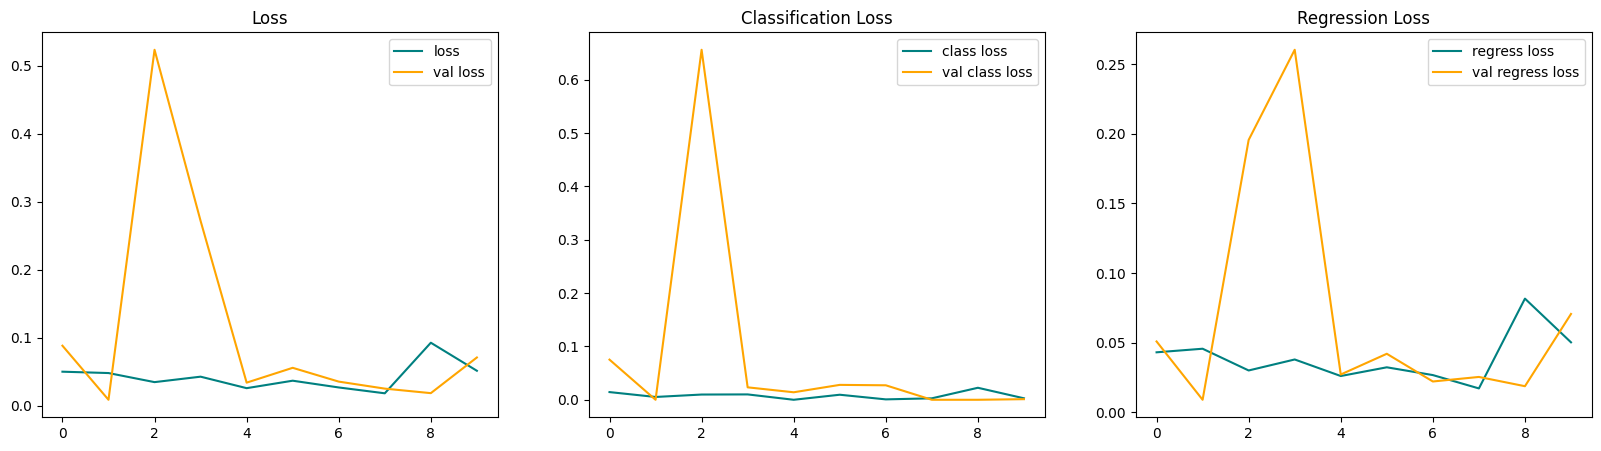

In [87]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [88]:
test_data = test.as_numpy_iterator()

In [89]:
test_sample = test_data.next()

In [90]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 330ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


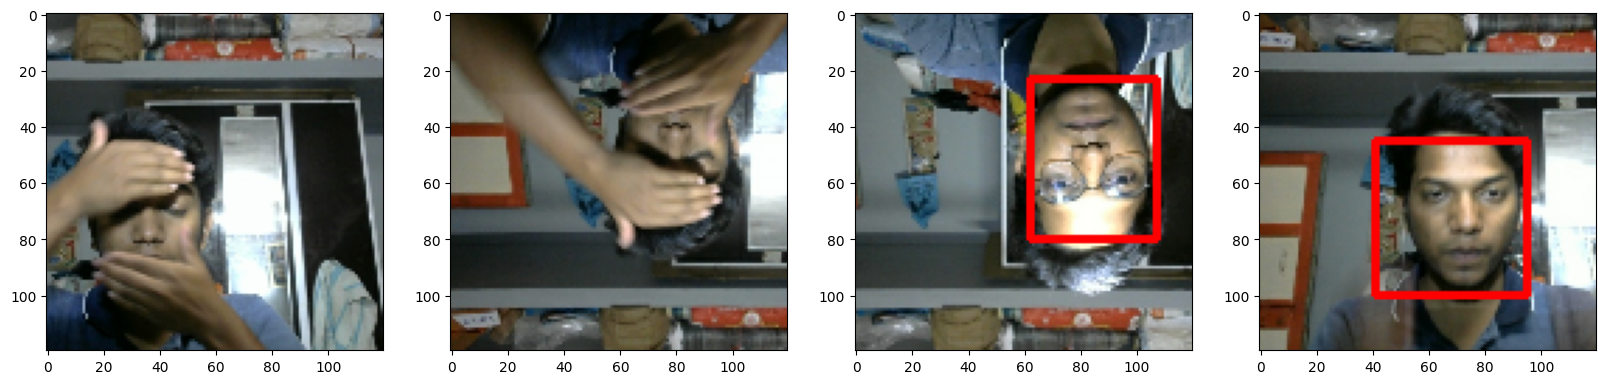

In [92]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))

for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]

    if yhat[0][idx] > 0.9:
        sample_image_umat = cv2.UMat(sample_image)

        cv2.rectangle(sample_image_umat,
                      tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)),
                      (255, 0, 0), 2)

        sample_image_with_rectangle = np.asarray(sample_image_umat.get())
    else:
        sample_image_with_rectangle = sample_image

    ax[idx].imshow(sample_image_with_rectangle)

plt.show()


### 11.2 Save the Model

In [5]:
from tensorflow.keras.models import load_model
import cv2

In [2]:
facetracker.save('Face_Tracking.h5')

NameError: name 'facetracker' is not defined

In [3]:
FaceTracker = load_model('Face_Tracking.h5')

### 11.3 Real Time Detection

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = FaceTracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('FaceTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()